In [1]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np



AMBIL DATA DARI YAHOO FINANCE

In [2]:
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'

panel_data = data.DataReader(tickers,'yahoo',start_date, end_date)
panel_data.head(5)


KeyboardInterrupt: 

In [ ]:
data_close = panel_data["Close"]
data_close.head(5).round(2)

Symbols,ANTM.JK,ASII.JK,ICBP.JK,JSMR.JK
Date,,,,
2010-01-04,1931.95,3530.0,1837.5,1845.68
2010-01-05,1931.95,3550.0,1875.0,1865.63
2010-01-06,1931.95,3530.0,1862.5,1875.61
2010-01-07,1973.95,3420.0,1875.0,1865.63
2010-01-08,1973.95,3440.0,1887.5,1855.65


### Deskripsi Data

In [ ]:
data_close.describe().round(2)

Symbols,ANTM.JK,ASII.JK,ICBP.JK,JSMR.JK
count,3073.00,3073.00,3073.00,3073.00
mean,1178.16,6688.56,6745.44,4787.32
std,603.01,1202.76,2861.54,1181.79
min,287.00,3280.00,1675.00,1686.05
25%,760.00,5850.00,4050.00,3980.00
50%,955.00,6900.00,7550.00,4870.00
75%,1595.96,7600.00,8850.00,5686.68
max,3190.00,9150.00,12400.00,7183.18


Ploting Data saham

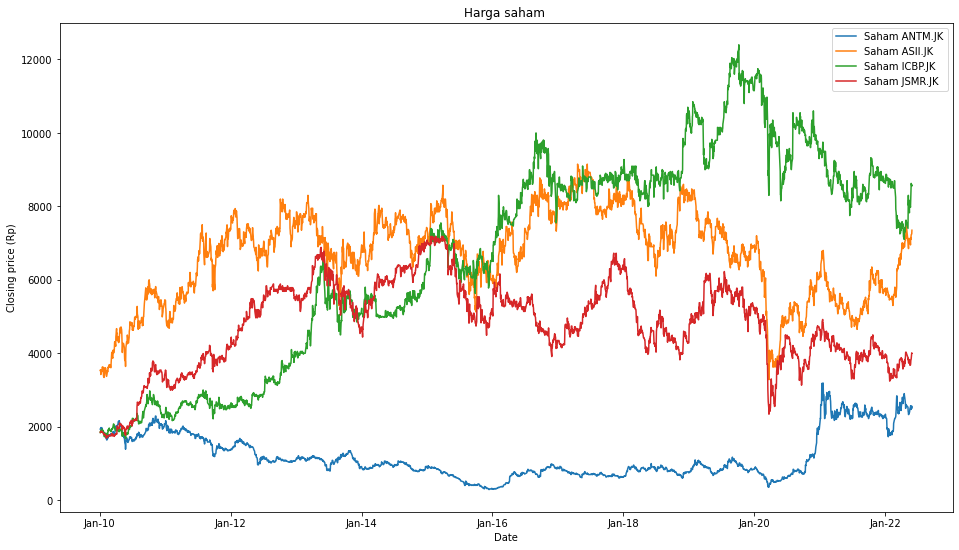

In [ ]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in tickers:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

### CHANGE COLUMN NAMES

In [ ]:
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close

,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1931.946777,3530.0,1837.5,1845.677368
2010-01-05,1931.946777,3550.0,1875.0,1865.630737
2010-01-06,1931.946777,3530.0,1862.5,1875.607300
2010-01-07,1973.945557,3420.0,1875.0,1865.630737
2010-01-08,1973.945557,3440.0,1887.5,1855.654053
...,...,...,...,...
2022-05-24,2570.000000,7150.0,8150.0,3720.000000
2022-05-25,2490.000000,7100.0,8250.0,3800.000000
2022-05-27,2470.000000,7225.0,8625.0,3850.000000


## Normalise Data

In [ ]:
df_antm = pd.DataFrame(data_close.antm)
df_asii = pd.DataFrame(data_close.asii)
df_icbp = pd.DataFrame(data_close.icbp)
df_jsmr = pd.DataFrame(data_close.jsmr)

In [ ]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm = pd.DataFrame(scaler.fit_transform(df_antm), columns = ['antm'])
df_asii = pd.DataFrame(scaler.fit_transform(df_asii), columns = ['asii'])
df_icbp = pd.DataFrame(scaler.fit_transform(df_icbp), columns = ['icbp'])
df_jsmr = pd.DataFrame(scaler.fit_transform(df_jsmr), columns = ['jsmr'])



In [ ]:
# convert to windowed data sets
ylist_antm = list(df_antm['antm'])
ylist_asii = list(df_asii['asii'])
ylist_icbp = list(df_icbp['icbp'])
ylist_jsmr = list(df_jsmr['jsmr'])

In [ ]:
#LAGS and PERIOD
n_future = 72
n_past = 3*72
total_period = 4*72

## PREPARING DATASET

### ANTM DATASET

In [ ]:
idx_end_antm = len(ylist_antm)
idx_start_antm = idx_end_antm - total_period

X_new_antm = []
y_new_antm = []

while idx_start_antm > 0:
  x_line_antm = ylist_antm[idx_start_antm:idx_start_antm+n_past]
  y_line_antm = ylist_antm[idx_start_antm+n_past:idx_start_antm+total_period]

  X_new_antm.append(x_line_antm)
  y_new_antm.append(y_line_antm)

  idx_start_antm = idx_start_antm - 1

import numpy as np
X_new_antm = np.array(X_new_antm)
y_new_antm = np.array(y_new_antm)

# train test split
from sklearn.model_selection import train_test_split
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(X_new_antm, y_new_antm, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_antm.shape[0]
n_timesteps = X_train_antm.shape[1]
n_steps = y_train_antm.shape[1]
n_features = 1

X_train_rs_antm = X_train_antm.reshape(n_samples, n_timesteps, n_features )
X_test_rs_antm = X_test_antm.reshape(X_test_antm.shape[0], n_timesteps, n_features )


### ASII DATASET

In [ ]:
idx_end_asii = len(ylist_asii)
idx_start_asii = idx_end_asii - total_period

X_new_asii = []
y_new_asii = []

while idx_start_asii > 0:
  x_line_asii = ylist_asii[idx_start_asii:idx_start_asii+n_past]
  y_line_asii = ylist_asii[idx_start_asii+n_past:idx_start_asii+total_period]

  X_new_asii.append(x_line_asii)
  y_new_asii.append(y_line_asii)

  idx_start_asii = idx_start_asii - 1

import numpy as np
X_new_asii = np.array(X_new_asii)
y_new_asii = np.array(y_new_asii)

# train test split
from sklearn.model_selection import train_test_split
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(X_new_asii, y_new_asii, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_asii.shape[0]
n_timesteps = X_train_asii.shape[1]
n_steps = y_train_asii.shape[1]
n_features = 1

X_train_rs_asii = X_train_asii.reshape(n_samples, n_timesteps, n_features )
X_test_rs_asii = X_test_asii.reshape(X_test_asii.shape[0], n_timesteps, n_features )

### ICBP DATASET

In [ ]:
idx_end_icbp = len(ylist_icbp)
idx_start_icbp = idx_end_icbp - total_period

X_new_icbp = []
y_new_icbp = []

while idx_start_icbp > 0:
  x_line_icbp = ylist_icbp[idx_start_icbp:idx_start_icbp+n_past]
  y_line_icbp = ylist_icbp[idx_start_icbp+n_past:idx_start_icbp+total_period]

  X_new_icbp.append(x_line_icbp)
  y_new_icbp.append(y_line_icbp)

  idx_start_icbp = idx_start_icbp - 1

import numpy as np
X_new_icbp = np.array(X_new_icbp)
y_new_icbp = np.array(y_new_icbp)

# train test split
from sklearn.model_selection import train_test_split
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(X_new_icbp, y_new_icbp, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_icbp.shape[0]
n_timesteps = X_train_icbp.shape[1]
n_steps = y_train_icbp.shape[1]
n_features = 1

X_train_rs_icbp = X_train_icbp.reshape(n_samples, n_timesteps, n_features )
X_test_rs_icbp = X_test_icbp.reshape(X_test_icbp.shape[0], n_timesteps, n_features )

### JSMR DATASET

In [ ]:
idx_end_jsmr = len(ylist_jsmr)
idx_start_jsmr = idx_end_jsmr - total_period

X_new_jsmr = []
y_new_jsmr = []

while idx_start_jsmr > 0:
  x_line_jsmr = ylist_jsmr[idx_start_jsmr:idx_start_jsmr+n_past]
  y_line_jsmr = ylist_jsmr[idx_start_jsmr+n_past:idx_start_jsmr+total_period]

  X_new_jsmr.append(x_line_jsmr)
  y_new_jsmr.append(y_line_jsmr)

  idx_start_jsmr = idx_start_jsmr - 1

import numpy as np
X_new_jsmr = np.array(X_new_jsmr)
y_new_jsmr = np.array(y_new_jsmr)

# train test split
from sklearn.model_selection import train_test_split
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(X_new_jsmr, y_new_jsmr, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train_jsmr.shape[0]
n_timesteps = X_train_jsmr.shape[1]
n_steps = y_train_jsmr.shape[1]
n_features = 1

X_train_rs_jsmr = X_train_jsmr.reshape(n_samples, n_timesteps, n_features )
X_test_rs_jsmr = X_test_jsmr.reshape(X_test_jsmr.shape[0], n_timesteps, n_features )

# LSTM SECTION

## ONE LAYER LSTM MODEL

### ANTM SECTION

In [ ]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_antm = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_antm.shape[1]),
])

simple_model_one_antm.summary()

simple_model_one_antm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_one_antm = simple_model_one_antm.fit(X_train_rs_antm, y_train_antm,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_one_antm = simple_model_one_antm.predict(X_test_rs_antm)

print(r2_score(preds_one_antm, y_test_antm))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 72)                648       
                                                                 
Total params: 968
Trainable params: 968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 6s 85ms/step - loss: 0.1116 - mean_absolute_error: 0.1116 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572
Epoch 2/5
47/47 [==============================] - 3s 68ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0451 - val_mean_absolute_error: 0.0451
Epoch 3/5
47/47 [==============================] - 3s 68ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0445 

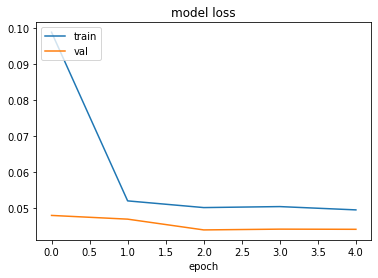

In [ ]:
#Summarize model loss
plt.plot(smod_history_one_antm.history['loss'])
plt.plot(smod_history_one_antm.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### ASII SECTION

In [ ]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_asii = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_asii.shape[1]),
])

simple_model_one_asii.summary()

simple_model_one_asii.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_one_asii = simple_model_one_asii.fit(X_train_rs_asii, y_train_asii,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_one_asii = simple_model_one_asii.predict(X_test_rs_asii)

print(r2_score(preds_one_asii, y_test_asii))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_1 (Dense)             (None, 72)                648       
                                                                 
Total params: 968
Trainable params: 968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 5s 79ms/step - loss: 0.2103 - mean_absolute_error: 0.2103 - val_loss: 0.0891 - val_mean_absolute_error: 0.0891
Epoch 2/5
47/47 [==============================] - 3s 69ms/step - loss: 0.0822 - mean_absolute_error: 0.0822 - val_loss: 0.0817 - val_mean_absolute_error: 0.0817
Epoch 3/5
47/47 [==============================] - 3s 73ms/step - loss: 0.0803 - mean_absolute_error: 0.0803 - val_loss: 0.0801 

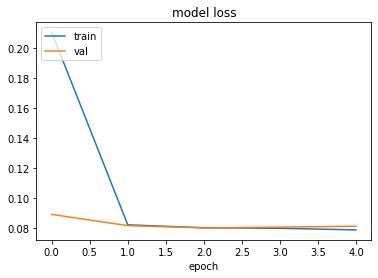

In [ ]:
#Summarize model loss
plt.plot(smod_history_one_asii.history['loss'])
plt.plot(smod_history_one_asii.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### ICBP SECTION

In [ ]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_icbp = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_icbp.shape[1]),
])

simple_model_one_icbp.summary()

simple_model_one_icbp.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_one_icbp = simple_model_one_icbp.fit(X_train_rs_icbp, y_train_icbp,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_one_icbp = simple_model_one_icbp.predict(X_test_rs_icbp)

print(r2_score(preds_one_icbp, y_test_icbp))



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 72)                648       
                                                                 
Total params: 968
Trainable params: 968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 6s 81ms/step - loss: 0.1723 - mean_absolute_error: 0.1723 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 2/5
47/47 [==============================] - 4s 75ms/step - loss: 0.0437 - mean_absolute_error: 0.0437 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405
Epoch 3/5
47/47 [==============================] - 3s 70ms/step - loss: 0.0400 - mean_absolute_error: 0.0400 - val_loss: 0.0406 

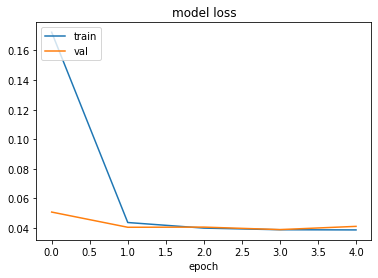

In [ ]:
#Summarize model loss
plt.plot(smod_history_one_icbp.history['loss'])
plt.plot(smod_history_one_icbp.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### JSMR SECTION

In [ ]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_one_jsmr = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_jsmr.shape[1]),
])

simple_model_one_jsmr.summary()

simple_model_one_jsmr.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_one_jsmr = simple_model_one_jsmr.fit(X_train_rs_jsmr, y_train_jsmr,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_one_jsmr = simple_model_one_jsmr.predict(X_test_rs_jsmr)

print(r2_score(preds_one_jsmr, y_test_jsmr))



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 72)                648       
                                                                 
Total params: 968
Trainable params: 968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 5s 81ms/step - loss: 0.2101 - mean_absolute_error: 0.2101 - val_loss: 0.0871 - val_mean_absolute_error: 0.0871
Epoch 2/5
47/47 [==============================] - 3s 71ms/step - loss: 0.0794 - mean_absolute_error: 0.0794 - val_loss: 0.0726 - val_mean_absolute_error: 0.0726
Epoch 3/5
47/47 [==============================] - 3s 70ms/step - loss: 0.0742 - mean_absolute_error: 0.0742 - val_loss: 0.0684 

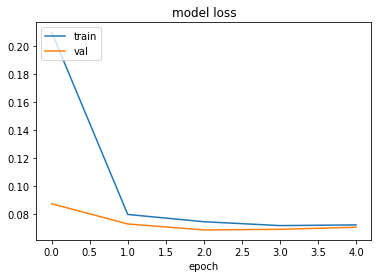

In [ ]:
#Summarize model loss
plt.plot(smod_history_one_jsmr.history['loss'])
plt.plot(smod_history_one_jsmr.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### MODEL LOSS COMPARISON (1 layer)

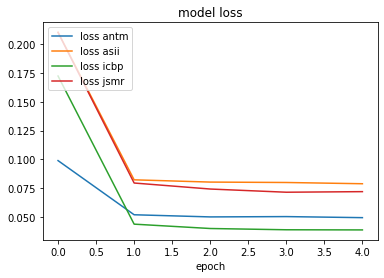

In [ ]:
plt.plot(smod_history_one_antm.history['loss'], label='loss antm')
plt.plot(smod_history_one_asii.history['loss'], label = 'loss asii')
plt.plot(smod_history_one_icbp.history['loss'], label = 'loss icbp' )
plt.plot(smod_history_one_jsmr.history['loss'], label = 'loss jsmr')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')

### METRICS EVALUATION (1 layer)

#### R2 score

In [ ]:
# R2 score
print("R2 score antm: "+str(r2_score(preds_one_antm, y_test_antm).round(2)))
print("R2 score asii: "+str(r2_score(preds_one_asii, y_test_asii).round(2)))
print("R2 score icbp: "+str(r2_score(preds_one_icbp, y_test_icbp).round(2)))
print("R2 score jsmr: "+str(r2_score(preds_one_jsmr, y_test_jsmr).round(2)))

R2 score antm: 0.77
R2 score asii: 0.3
R2 score icbp: 0.93
R2 score jsmr: 0.54


#### MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

# R2 score
print("R2 score antm: "+str(mean_absolute_error(preds_one_antm, y_test_antm).round(2)))
print("R2 score asii: "+str(mean_absolute_error(preds_one_asii, y_test_asii).round(2)))
print("R2 score icbp: "+str(mean_absolute_error(preds_one_icbp, y_test_icbp).round(2)))
print("R2 score jsmr: "+str(mean_absolute_error(preds_one_jsmr, y_test_jsmr).round(2)))


R2 score antm: 0.05
R2 score asii: 0.08
R2 score icbp: 0.04
R2 score jsmr: 0.07


## THREE LAYER LSTM MODEL

### ANTM SECTION

In [ ]:
random.seed(42)

simple_model_three_antm = Sequential([
   LSTM(64, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
  Dense(y_train_antm.shape[1]),
])

simple_model_three_antm.summary()

simple_model_three_antm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_three_antm = simple_model_three_antm.fit(X_train_rs_antm, y_train_antm,
          validation_split=0.2,
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds_three_antm = simple_model_three_antm.predict(X_test_rs_antm)

print(r2_score(preds_three_antm, y_test_antm))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 216, 64)           16896     
                                                                 
 lstm_5 (LSTM)               (None, 216, 64)           33024     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 72)                4680      
                                                                 
Total params: 87,624
Trainable params: 87,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
47/47 [==============================] - 19s 300ms/step - loss: 0.1211 - mean_absolute_error: 0.1211 - val_loss: 0.0500 - val_mean_absolute_error: 0.0500
Epoch 2/10
47/47 

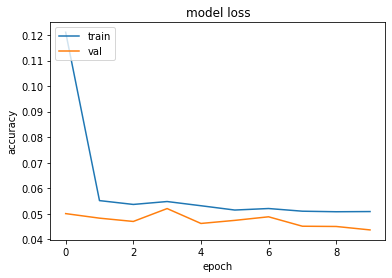

In [ ]:
plt.plot(smod_history_three_antm.history['loss'])
plt.plot(smod_history_three_antm.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### ASII SECTION

In [ ]:
random.seed(42)

simple_model_three_asii = Sequential([
   LSTM(64, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
  Dense(y_train_asii.shape[1]),
])

simple_model_three_asii.summary()

simple_model_three_asii.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_three_asii = simple_model_three_asii.fit(X_train_rs_asii, y_train_asii,
          validation_split=0.2,
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds_three_asii = simple_model_three_asii.predict(X_test_rs_asii)

print(r2_score(preds_three_asii, y_test_asii))



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 216, 64)           16896     
                                                                 
 lstm_8 (LSTM)               (None, 216, 64)           33024     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 72)                4680      
                                                                 
Total params: 87,624
Trainable params: 87,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22/47 [=============>................] - ETA: 6s - loss: 0.3740 - mean_absolute_error: 0.3740

KeyboardInterrupt: 

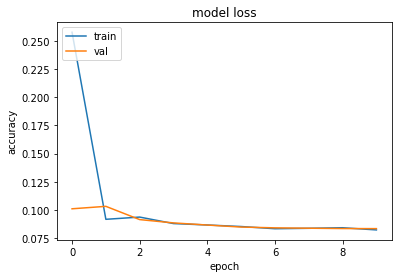

In [ ]:
plt.plot(smod_history_three_asii.history['loss'])
plt.plot(smod_history_three_asii.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### ICBP SECTION

In [ ]:
random.seed(42)

simple_model_three_icbp = Sequential([
   LSTM(64, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
  Dense(y_train_icbp.shape[1]),
])

simple_model_three_icbp.summary()

simple_model_three_icbp.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_three_icbp = simple_model_three_icbp.fit(X_train_rs_icbp, y_train_icbp,
          validation_split=0.2,
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds_three_icbp = simple_model_three_icbp.predict(X_test_rs_icbp)

print(r2_score(preds_three_icbp, y_test_icbp))



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 216, 64)           16896     
                                                                 
 lstm_15 (LSTM)              (None, 216, 64)           33024     
                                                                 
 lstm_16 (LSTM)              (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 72)                4680      
                                                                 
Total params: 87,624
Trainable params: 87,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
47/47 [==============================] - 20s 307ms/step - loss: 0.1809 - mean_absolute_error: 0.1809 - val_loss: 0.0504 - val_mean_absolute_error: 0.0504
Epoch 2/10
47/47 

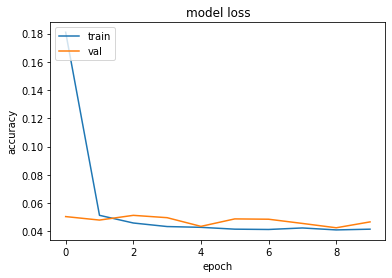

In [ ]:
plt.plot(smod_history_three_icbp.history['loss'])
plt.plot(smod_history_three_icbp.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### JSMR SECTION

In [ ]:
random.seed(42)

simple_model_three_jsmr = Sequential([
   LSTM(64, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
  Dense(y_train_jsmr.shape[1]),
])

simple_model_three_jsmr.summary()

simple_model_three_jsmr.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_three_jsmr = simple_model_three_jsmr.fit(X_train_rs_jsmr, y_train_jsmr,
          validation_split=0.2,
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds_three_jsmr = simple_model_three_jsmr.predict(X_test_rs_jsmr)

print(r2_score(preds_three_jsmr, y_test_jsmr))



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 216, 64)           16896     
                                                                 
 lstm_18 (LSTM)              (None, 216, 64)           33024     
                                                                 
 lstm_19 (LSTM)              (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 72)                4680      
                                                                 
Total params: 87,624
Trainable params: 87,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
47/47 [==============================] - 19s 290ms/step - loss: 0.2348 - mean_absolute_error: 0.2348 - val_loss: 0.0938 - val_mean_absolute_error: 0.0938
Epoch 2/10
47/47 

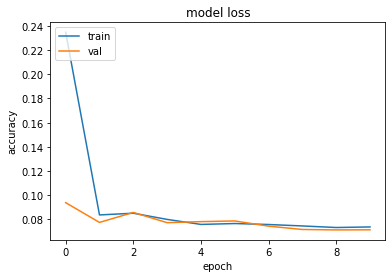

In [ ]:
plt.plot(smod_history_three_jsmr.history['loss'])
plt.plot(smod_history_three_jsmr.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### MODEL LOSS COMPARISON (3 layer)

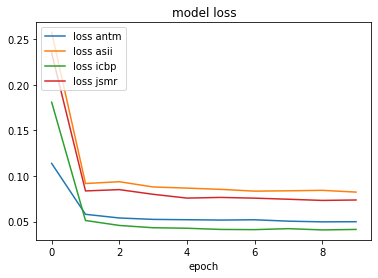

In [ ]:
plt.plot(smod_history_three_antm.history['loss'], label='loss antm')
plt.plot(smod_history_three_asii.history['loss'], label = 'loss asii')
plt.plot(smod_history_three_icbp.history['loss'], label = 'loss icbp' )
plt.plot(smod_history_three_jsmr.history['loss'], label = 'loss jsmr')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')

### METRIC EVALUATION

#### R2 score

In [ ]:
# R2 score
print("R2 score antm: "+str(r2_score(preds_three_antm, y_test_antm).round(2)))
print("R2 score asii: "+str(r2_score(preds_three_asii, y_test_asii).round(2)))
print("R2 score icbp: "+str(r2_score(preds_three_icbp, y_test_icbp).round(2)))
print("R2 score jsmr: "+str(r2_score(preds_three_jsmr, y_test_jsmr).round(2)))

R2 score antm: 0.73
R2 score asii: 0.13
R2 score icbp: 0.94
R2 score jsmr: 0.57


#### MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

# R2 score
print("R2 score antm: "+str(mean_absolute_error(preds_three_antm, y_test_antm).round(2)))
print("R2 score asii: "+str(mean_absolute_error(preds_three_asii, y_test_asii).round(2)))
print("R2 score icbp: "+str(mean_absolute_error(preds_three_icbp, y_test_icbp).round(2)))
print("R2 score jsmr: "+str(mean_absolute_error(preds_three_jsmr, y_test_jsmr).round(2)))


R2 score antm: 0.05


NameError: name 'preds_three_asii' is not defined

## PLOT MODEL

# RNN SECTION

## ONE LAYER RNN

### ANTM

In [ ]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_antm = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_antm.shape[1]),
])


simple_model_rnn_one_antm.summary()

simple_model_rnn_one_antm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_antm = simple_model_rnn_one_antm.fit(X_train_rs_antm, y_train_antm,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_antm = simple_model_rnn_one_antm.predict(X_test_rs_antm)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_2 (Dense)             (None, 72)                648       
                                                                 
Total params: 728
Trainable params: 728
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 3s 45ms/step - loss: 0.2233 - mean_absolute_error: 0.2233 - val_loss: 0.1567 - val_mean_absolute_error: 0.1567
Epoch 2/5
47/47 [==============================] - 2s 40ms/step - loss: 0.1274 - mean_absolute_error: 0.1274 - val_loss: 0.0941 - val_mean_absolute_error: 0.0941
Epoch 3/5
47/47 [==============================] - 2s 43ms/step - loss: 0.0856 - mean_absolute_error: 0.0856 - val_loss: 0.0708 

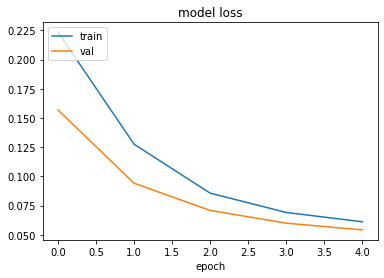

In [ ]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_antm.history['loss'])
plt.plot(smod_history_rnn_one_antm.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### ASII

In [ ]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_asii = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_asii.shape[1]),
])


simple_model_rnn_one_asii.summary()

simple_model_rnn_one_asii.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_asii = simple_model_rnn_one_asii.fit(X_train_rs_asii, y_train_asii,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_asii = simple_model_rnn_one_asii.predict(X_test_rs_asii)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_3 (Dense)             (None, 72)                648       
                                                                 
Total params: 728
Trainable params: 728
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 3s 49ms/step - loss: 0.4828 - mean_absolute_error: 0.4828 - val_loss: 0.3449 - val_mean_absolute_error: 0.3449
Epoch 2/5
47/47 [==============================] - 2s 44ms/step - loss: 0.2387 - mean_absolute_error: 0.2387 - val_loss: 0.1617 - val_mean_absolute_error: 0.1617
Epoch 3/5
47/47 [==============================] - 2s 51ms/step - loss: 0.1270 - mean_absolute_error: 0.1270 - val_loss: 0.1037 

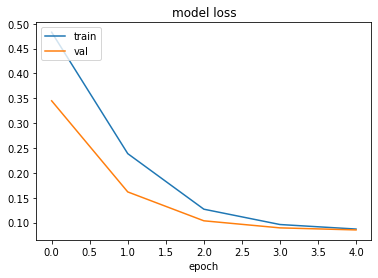

In [ ]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_asii.history['loss'])
plt.plot(smod_history_rnn_one_asii.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### ICBP

In [ ]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_icbp = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_icbp.shape[1]),
])


simple_model_rnn_one_icbp.summary()

simple_model_rnn_one_icbp.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_icbp = simple_model_rnn_one_icbp.fit(X_train_rs_icbp, y_train_icbp,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_icbp = simple_model_rnn_one_icbp.predict(X_test_rs_icbp)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 72)                648       
                                                                 
Total params: 728
Trainable params: 728
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 3s 47ms/step - loss: 0.3951 - mean_absolute_error: 0.3951 - val_loss: 0.2857 - val_mean_absolute_error: 0.2857
Epoch 2/5
47/47 [==============================] - 2s 39ms/step - loss: 0.2131 - mean_absolute_error: 0.2131 - val_loss: 0.1420 - val_mean_absolute_error: 0.1420
Epoch 3/5
47/47 [==============================] - 2s 43ms/step - loss: 0.1035 - mean_absolute_error: 0.1035 - val_loss: 0.0735 

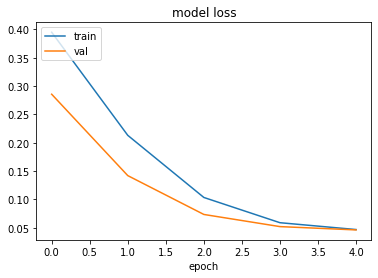

In [ ]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_icbp.history['loss'])
plt.plot(smod_history_rnn_one_icbp.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### JSMR

In [ ]:
import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model_rnn_one_jsmr = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train_jsmr.shape[1]),
])


simple_model_rnn_one_jsmr.summary()

simple_model_rnn_one_jsmr.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_one_jsmr = simple_model_rnn_one_jsmr.fit(X_train_rs_jsmr, y_train_jsmr,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_one_jsmr = simple_model_rnn_one_jsmr.predict(X_test_rs_jsmr)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_5 (Dense)             (None, 72)                648       
                                                                 
Total params: 728
Trainable params: 728
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 3s 41ms/step - loss: 0.5544 - mean_absolute_error: 0.5544 - val_loss: 0.4223 - val_mean_absolute_error: 0.4223
Epoch 2/5
47/47 [==============================] - 2s 40ms/step - loss: 0.2996 - mean_absolute_error: 0.2996 - val_loss: 0.2006 - val_mean_absolute_error: 0.2006
Epoch 3/5
47/47 [==============================] - 2s 40ms/step - loss: 0.1490 - mean_absolute_error: 0.1490 - val_loss: 0.1141 

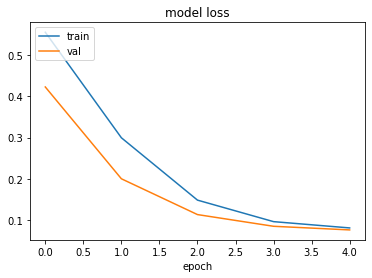

In [ ]:
import matplotlib.pyplot as plt
plt.plot(smod_history_rnn_one_jsmr.history['loss'])
plt.plot(smod_history_rnn_one_jsmr.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### MODEL LOSS COMPARISON

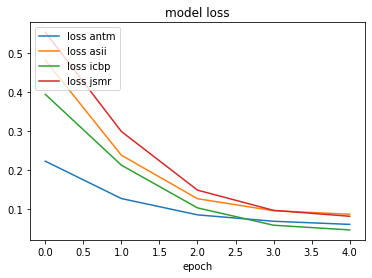

In [ ]:
plt.plot(smod_history_rnn_one_antm.history['loss'], label='loss antm')
plt.plot(smod_history_rnn_one_asii.history['loss'], label = 'loss asii')
plt.plot(smod_history_rnn_one_icbp.history['loss'], label = 'loss icbp' )
plt.plot(smod_history_rnn_one_jsmr.history['loss'], label = 'loss jsmr')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')

### METRICS EVALUATION

#### MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

# R2 score
print("R2 score antm: "+str(mean_absolute_error(preds_rnn_one_antm, y_test_antm).round(2)))
print("R2 score asii: "+str(mean_absolute_error(preds_rnn_one_asii, y_test_asii).round(2)))
print("R2 score icbp: "+str(mean_absolute_error(preds_rnn_one_icbp, y_test_icbp).round(2)))
print("R2 score jsmr: "+str(mean_absolute_error(preds_rnn_one_jsmr, y_test_jsmr).round(2)))


R2 score antm: 0.06
R2 score asii: 0.09
R2 score icbp: 0.05
R2 score jsmr: 0.08


#### R2 SCORE

In [ ]:
# R2 score
print("R2 score antm: "+str(r2_score(preds_rnn_one_antm, y_test_antm).round(2)))
print("R2 score asii: "+str(r2_score(preds_rnn_one_asii, y_test_asii).round(2)))
print("R2 score icbp: "+str(r2_score(preds_rnn_one_icbp, y_test_icbp).round(2)))
print("R2 score jsmr: "+str(r2_score(preds_rnn_one_jsmr, y_test_jsmr).round(2)))

R2 score antm: 0.58
R2 score asii: 0.16
R2 score icbp: 0.92
R2 score jsmr: 0.29


## THREE LAYER RNN

### ANTM

In [ ]:
random.seed(42)

simple_model_rnn_three_antm = Sequential([
  SimpleRNN(32, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(32, activation='tanh', return_sequences = True),
  SimpleRNN(32, activation='tanh'),
  Dense(y_train_antm.shape[1]),
])

simple_model_rnn_three_antm.summary()

simple_model_rnn_three_antm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_three_antm = simple_model_rnn_three_antm.fit(X_train_rs_antm, y_train_antm,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_three_antm = simple_model_rnn_three_antm.predict(X_test_rs_antm)




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 216, 32)           1088      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 216, 32)           2080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 72)                2376      
                                                                 
Total params: 7,624
Trainable params: 7,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 9s 137ms/step - loss: 0.1771 - mean_absolute_error: 0.1771 - val_loss: 0.0864 - val_mean_absolute_error: 0.0864
Epoch 2/5
47/47 [====

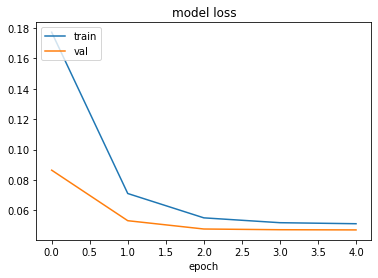

In [ ]:
plt.plot(smod_history_rnn_three_antm.history['loss'])
plt.plot(smod_history_rnn_three_antm.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### ASII

In [ ]:
random.seed(42)

simple_model_rnn_three_asii = Sequential([
  SimpleRNN(32, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(32, activation='tanh', return_sequences = True),
  SimpleRNN(32, activation='tanh'),
  Dense(y_train_asii.shape[1]),
])

simple_model_rnn_three_asii.summary()

simple_model_rnn_three_asii.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_three_asii = simple_model_rnn_three_asii.fit(X_train_rs_asii, y_train_asii,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_three_asii = simple_model_rnn_three_asii.predict(X_test_rs_asii)




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 216, 32)           1088      
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 216, 32)           2080      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 72)                2376      
                                                                 
Total params: 7,624
Trainable params: 7,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 8s 132ms/step - loss: 0.3102 - mean_absolute_error: 0.3102 - val_loss: 0.1222 - val_mean_absolute_error: 0.1222
Epoch 2/5
47/47 [====

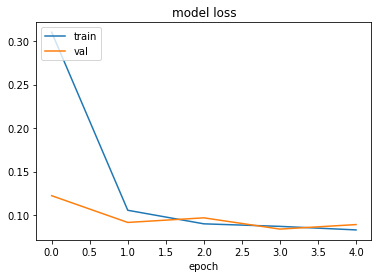

In [ ]:
plt.plot(smod_history_rnn_three_asii.history['loss'])
plt.plot(smod_history_rnn_three_asii.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### ICBP

In [ ]:
random.seed(42)

simple_model_rnn_three_icbp = Sequential([
  SimpleRNN(32, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(32, activation='tanh', return_sequences = True),
  SimpleRNN(32, activation='tanh'),
  Dense(y_train_icbp.shape[1]),
])

simple_model_rnn_three_icbp.summary()

simple_model_rnn_three_icbp.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_three_icbp = simple_model_rnn_three_icbp.fit(X_train_rs_icbp, y_train_icbp,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_three_icbp = simple_model_rnn_three_icbp.predict(X_test_rs_icbp)




Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 216, 32)           1088      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 216, 32)           2080      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 72)                2376      
                                                                 
Total params: 7,624
Trainable params: 7,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 9s 135ms/step - loss: 0.2608 - mean_absolute_error: 0.2608 - val_loss: 0.0961 - val_mean_absolute_error: 0.0961
Epoch 2/5
47/47 [====

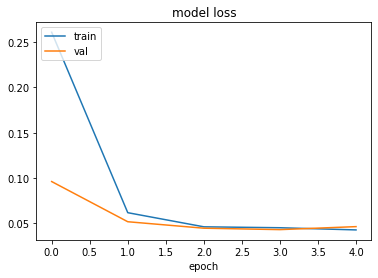

In [ ]:
plt.plot(smod_history_rnn_three_icbp.history['loss'])
plt.plot(smod_history_rnn_three_icbp.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### JSMR

In [ ]:
random.seed(42)

simple_model_rnn_three_jsmr = Sequential([
  SimpleRNN(32, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(32, activation='tanh', return_sequences = True),
  SimpleRNN(32, activation='tanh'),
  Dense(y_train_jsmr.shape[1]),
])

simple_model_rnn_three_jsmr.summary()

simple_model_rnn_three_jsmr.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history_rnn_three_jsmr = simple_model_rnn_three_jsmr.fit(X_train_rs_jsmr, y_train_jsmr,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds_rnn_three_jsmr = simple_model_rnn_three_jsmr.predict(X_test_rs_jsmr)




Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 216, 32)           1088      
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 216, 32)           2080      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 72)                2376      
                                                                 
Total params: 7,624
Trainable params: 7,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 8s 132ms/step - loss: 0.3116 - mean_absolute_error: 0.3116 - val_loss: 0.1308 - val_mean_absolute_error: 0.1308
Epoch 2/5
47/47 [====

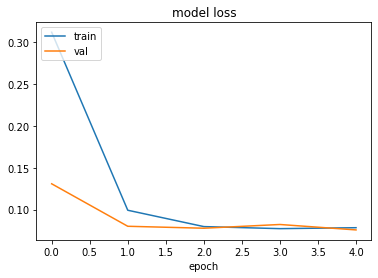

In [ ]:
plt.plot(smod_history_rnn_three_jsmr.history['loss'])
plt.plot(smod_history_rnn_three_jsmr.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### MODEL LOSS COMPARISON

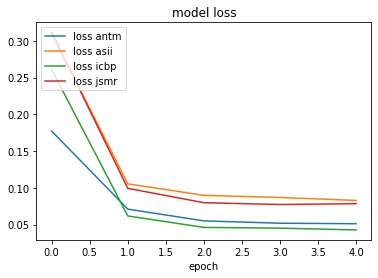

In [ ]:
plt.plot(smod_history_rnn_three_antm.history['loss'], label='loss antm')
plt.plot(smod_history_rnn_three_asii.history['loss'], label = 'loss asii')
plt.plot(smod_history_rnn_three_icbp.history['loss'], label = 'loss icbp' )
plt.plot(smod_history_rnn_three_jsmr.history['loss'], label = 'loss jsmr')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')

### METRIC EVALUATIOn

#### MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

# Mae score
print("Mae score antm: "+str(mean_absolute_error(preds_rnn_three_antm, y_test_antm).round(2)))
print("Mae score asii: "+str(mean_absolute_error(preds_rnn_three_asii, y_test_asii).round(2)))
print("Mae score icbp: "+str(mean_absolute_error(preds_rnn_three_icbp, y_test_icbp).round(2)))
print("Mae score jsmr: "+str(mean_absolute_error(preds_rnn_three_jsmr, y_test_jsmr).round(2)))


R2 score antm: 0.05
R2 score asii: 0.09
R2 score icbp: 0.05
R2 score jsmr: 0.08


#### R2 SCORE

In [ ]:
# R2 score
print("R2 score antm: "+str(r2_score(preds_rnn_three_antm, y_test_antm).round(2)))
print("R2 score asii: "+str(r2_score(preds_rnn_three_asii, y_test_asii).round(2)))
print("R2 score icbp: "+str(r2_score(preds_rnn_three_icbp, y_test_icbp).round(2)))
print("R2 score jsmr: "+str(r2_score(preds_rnn_three_jsmr, y_test_jsmr).round(2)))

R2 score antm: 0.79
R2 score asii: 0.18
R2 score icbp: 0.92
R2 score jsmr: 0.43


# COMPARISON PLOT MODEL BETWEEN LSTM AND RNN

## ONE LAYER

### MODEL LOSS COMPARISON

In [ ]:
plt.plot(smod_history_one_antm.history['loss'], label=' lstm loss antm')
plt.plot(smod_history_one_asii.history['loss'], label = 'lstm loss asii')
plt.plot(smod_history_one_icbp.history['loss'], label = 'lstm loss icbp' )
plt.plot(smod_history_one_jsmr.history['loss'], label = 'lstm loss jsmr')
plt.plot(smod_history_rnn_one_antm.history['loss'], label='rnn loss antm')
plt.plot(smod_history_rnn_one_asii.history['loss'], label = 'rnn loss asii')
plt.plot(smod_history_rnn_one_icbp.history['loss'], label = 'rnn loss icbp' )
plt.plot(smod_history_rnn_one_jsmr.history['loss'], label = 'rnn loss jsmr')

plt.title('model loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')

NameError: name 'plt' is not defined

## THREE LAYER

### MODEL LOSS COMPARISON

In [ ]:
plt.plot(smod_history_rnn_three_antm.history['loss'], label='rnn loss antm')
plt.plot(smod_history_rnn_three_asii.history['loss'], label = 'rnn loss asii')
plt.plot(smod_history_rnn_three_icbp.history['loss'], label = 'rnn loss icbp' )
plt.plot(smod_history_rnn_three_jsmr.history['loss'], label = 'rnn loss jsmr')
plt.plot(smod_history_three_antm.history['loss'], label='lstm loss antm')
plt.plot(smod_history_three_asii.history['loss'], label = 'lstm loss asii')
plt.plot(smod_history_three_icbp.history['loss'], label = 'lstm loss icbp' )
plt.plot(smod_history_three_jsmr.history['loss'], label = 'lstm loss jsmr')

plt.title('model loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')